# Microgrid Location Optimization
This notebook demonstrates how to solve the microgrid location optimization problem using quantum and classical optimization techniques with using DWave and Gurobi. We'll compare the results for both approaches and provide comprehensive visualizations.
    
## Table of Contents
1. Setup and Data Loading
2. Microgrid Location Generation
3. Cost Matrix Construction
4. DWave Quantum Optimization
5. Gurobi Classical Optimization
6. Results Analysis

## 1. Setup and Data Loading

In [198]:
# Required Libraries
import os
import sys
from pathlib import Path
path = str(Path(os.getcwd()))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import geodesic
import networkx as nx

# Load the dataset
df = pd.read_csv(path+'/Peninsula_pp.csv', delimiter=',', skiprows=0)
df

,Number,name,capacity(MW),latitude,longitude,primary_fuel,estimated_generation_gwh,Estimated cost for 1 year
0,1,Bukit Palong Solar Power Plant,3.0,2.5823,101.8313,Solar,2.419183,2.935532e+05
1,2,Gebeng Solar Power Plant,10.0,3.9924,103.3682,Solar,8.063943,9.785106e+05
2,3,Gemas Solar Power Plant,10.2,2.5956,102.6216,Solar,8.225222,9.980809e+05
3,4,Hijau Solar Power Plant,8.0,2.3409,102.2168,Solar,6.451155,7.828085e+05
4,5,Jasin,50.0,2.3400,102.3500,Solar,40.319716,4.892553e+06
5,6,Kuala Langat,50.0,2.7450,101.5600,Solar,40.319716,4.892553e+06
6,7,Kuala Lumpur Airport Solar Power Plant,19.0,2.7791,101.7144,Solar,15.321492,1.859170e+06
7,8,Kuala Perlis Solar Power Plant,6.0,6.4105,100.1378,Solar,4.838366,5.871064e+05
8,9,Kuala Sawah Solar Power Plant,5.3,2.6355,101.9404,Solar,4.273890,5.186106e+05
9,10,Merchang,50.0,4.9340,103.3360,Solar,40.319716,4.892553e+06


In [199]:
# Extract relevant columns
ind = df['Number']
name = df['name']
lat = df['latitude']
long = df['longitude']
capacity = df['capacity(MW)']
penetration = df['Estimated cost for 1 year']
locations = {ind: (lat, long) for ind, lat, long in zip(ind, lat, long)}

## 2. Microgrid Location Generation

In [200]:
import scipy.sparse as sp
from networkx.algorithms import community

### create QUBO matrix
# define the distance matrix
num_powerplants = (len(locations.keys())) ## number of solar power plants
pplat, pplong = zip(*locations.values())

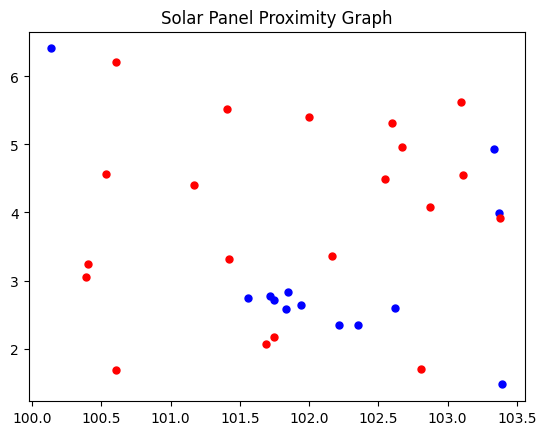

In [201]:
# Generate microgrid locations
num_microgrids = 20 ## number of microgrids
random = np.random.default_rng(seed=45)
random_lat = random.uniform(min(lat), max(lat), size=4*num_microgrids)
lat_choices = random.choice(random_lat, size=num_microgrids, replace=False)

random_long = random.uniform(min(long), max(long), size=4*num_microgrids)
long_choices = random.choice(random_long, size=num_microgrids, replace=False)

# Visualize Graph
fig, ax = plt.subplots()
ax.plot(long, lat, 'o', markersize=5, color='blue')
ax.plot(long_choices, lat_choices, 'o', markersize=5, color='red')
plt.title("Solar Panel Proximity Graph")
plt.show()

## 3. Cost Matrix Construction

In [202]:
def calculate_distance_mgpp(mglat, mglong, pplat, pplong):    
    distance_matrix = np.zeros(len(pplat))
    for i in range(len(pplat)):
        distance_matrix[i] = geodesic((mglat, mglong), (pplat[i], pplong[i])).km
    return distance_matrix

def calculate_distance_mgmg(mglat, mglong):    
    distance_matrix = np.zeros((len(mglat), len(mglat)))
    for i in range(len(mglat)):
        for j in range(len(mglat)):
            if i < j:
                distance_matrix[i][j] = geodesic((mglat[i], mglong[i]), (mglat[j], mglong[j])).km
    return distance_matrix

mgpp_distance = np.zeros(num_microgrids)
for i in range(num_microgrids):
    mgpp_distance[i] = np.sum(calculate_distance_mgpp(lat_choices[i], long_choices[i],pplat, pplong))

mgmg_distance = calculate_distance_mgmg(lat_choices, long_choices)

In [203]:
costCoeff = 10000
mgpp_cost = mgpp_distance * costCoeff
mgmg_cost = mgmg_distance * costCoeff

battery_cost = 38000  # Example fixed cost for battery and inverter installation
solar_cost = 13000  # Example fixed cost for solar panel installation
fixedCost = battery_cost + solar_cost

In [204]:
def add_count_constraint(K, delta, N):
    """
    Adds a count constraint penalty to QUBO: (sum x_i - K)^2
    Args:
        Q: dict of QUBO terms (modified in-place)
        K: number of locations to select
        delta: penalty strength
        N: total number of candidate locations
    """
    Q = np.zeros((N, N))
    for i in range(N):
        Q[(i, i)] += delta * (1 - 2 * K)
        for j in range(i + 1, N):
            Q[(i, j)] += 2 * delta
    return Q

In [205]:
## budget constraint
penaltyTerm = add_count_constraint(5, 100000, num_microgrids)
penaltyTerm

array([[-900000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.],
       [      0., -900000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.],
       [      0.,       0., -900000.,  200000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.],
       [      0.,       0.,       0., -900000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.,  200000.,  200000.,  200000.,  200000.,
         200000.,  200000.],
       [      0.,       0.,       0.,       0., -900000.,  200000.,


In [206]:
### QUBO matrix
term1 = (fixedCost*np.ones((1, num_microgrids))) - (sum(np.array(penetration)))*np.ones((1, num_microgrids)) + mgpp_cost
linearTerm = np.zeros((num_microgrids, num_microgrids))
for i in range(num_microgrids):
    linearTerm[i,i] = term1[0,i]
quandTerm = mgmg_cost

qubo_matrix = linearTerm + quandTerm + penaltyTerm

## 4. DWave Quantum Optimization

In [207]:
from autoqubo import SamplingCompiler, Utils
import timeit

start = timeit.default_timer()

solutions, energy_values = Utils.solve(qubo_matrix)

stop = timeit.default_timer()

quantum_solution = solutions[0]  # Best quantum solution
quantum_energy = energy_values[0]
quantum_time = stop - start  # Time from DWave execution
quantum_metrics = calculate_metrics(quantum_solution)

print('Time: ', quantum_time)

for s, e in zip(solutions, energy_values):
    print(f"x={s}, energy={e}")

Time:  0.006078750011511147
x=[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], energy=-8238383.8220144


## 5. Gurobi Classical Optimization

In [208]:
from gurobi_optimods.qubo import solve_qubo

start = timeit.default_timer()
 
result = solve_qubo(qubo_matrix)

stop = timeit.default_timer()

classical_solution = result.solution
classical_energy = result.objective_value
classical_time = stop - start  # Time from Gurobi execution (you may need to recalculate this)
classical_metrics = calculate_metrics(classical_solution)

print('Time: ', classical_time)

New QUBO solution found with objective 0.0
New QUBO solution found with objective -8238383.8220144
Time:  0.01025012496393174


## 6. Results Analysis

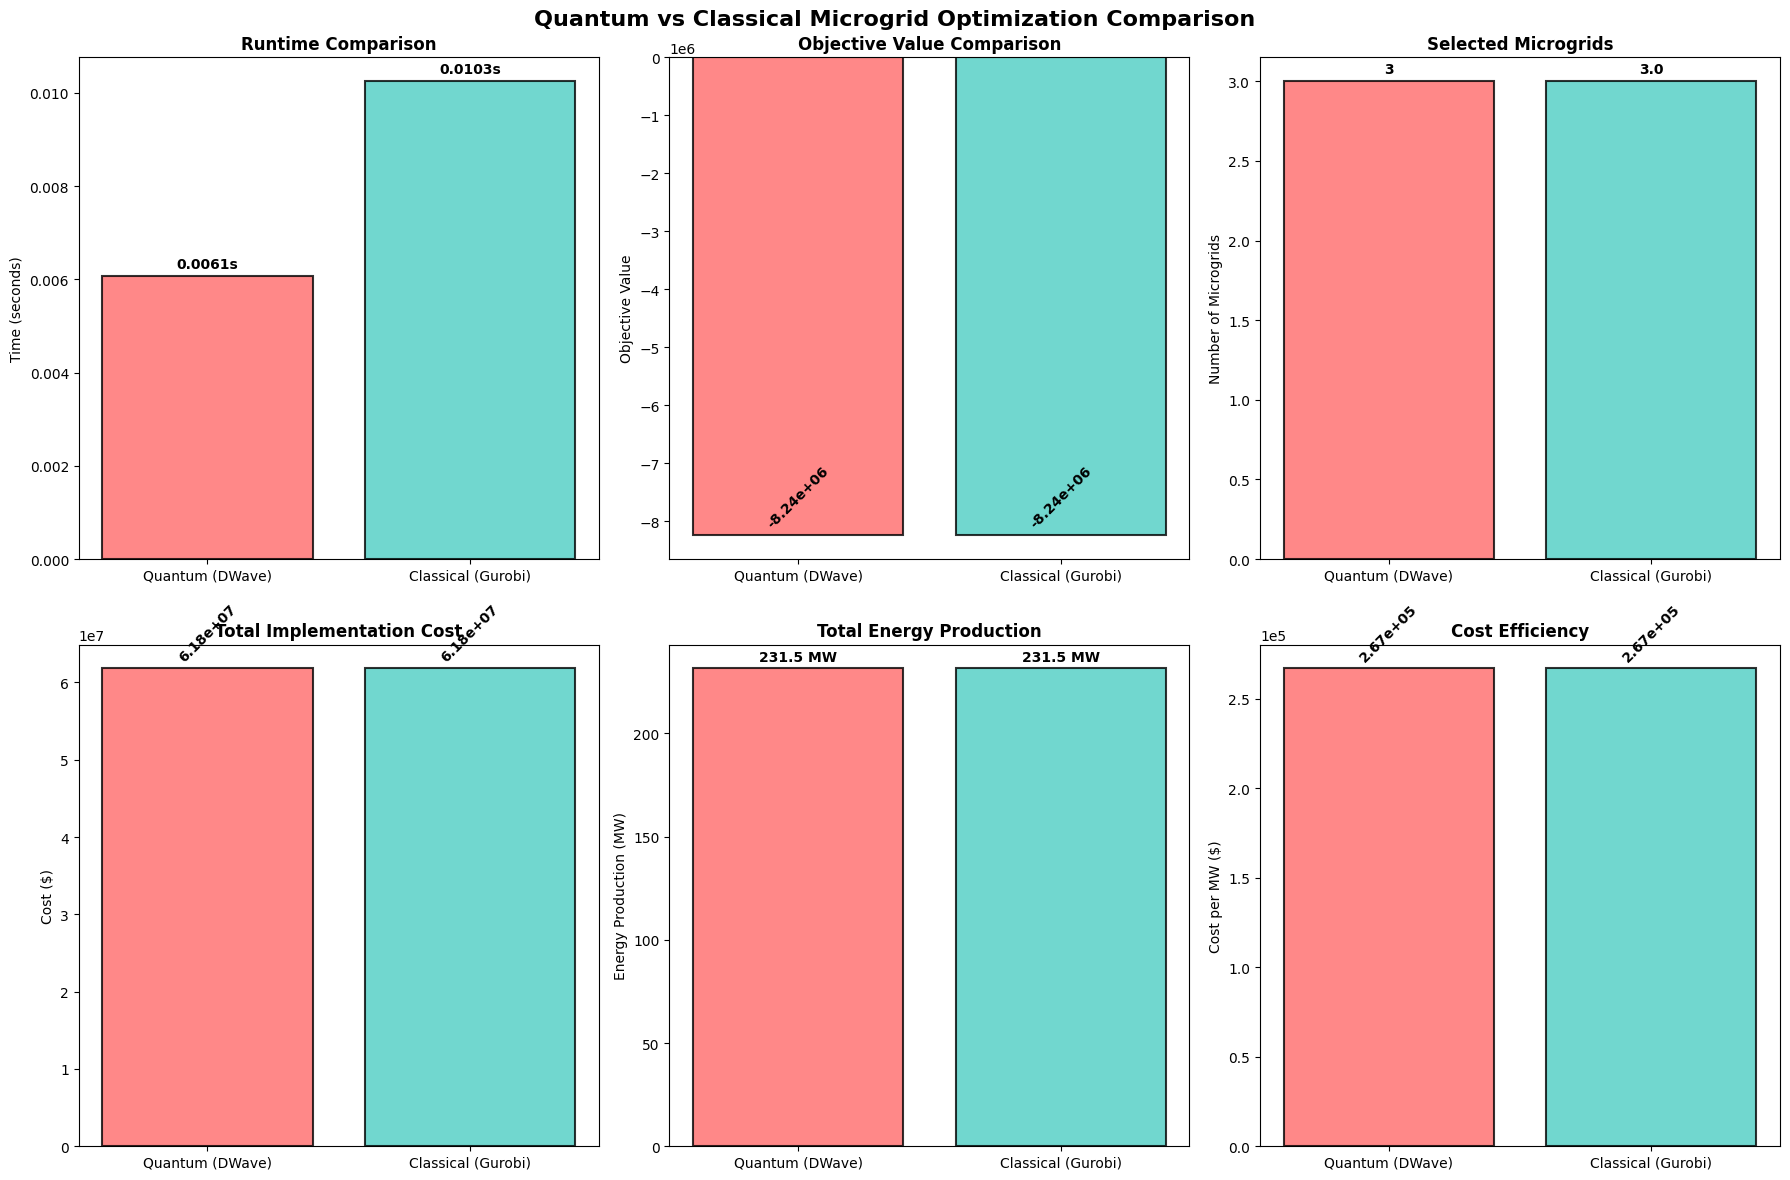


DETAILED COMPARISON RESULTS
Metric                    Quantum (DWave)      Classical (Gurobi)   Difference     
--------------------------------------------------------------------------------
Runtime (s)               0.006079             0.010250             0.004171       
Objective Value           -8.24e+06            -8.24e+06            0.00e+00       
Selected Microgrids       3                    3.0                  0.0            
Total Cost ($)            6.18e+07             6.18e+07             0.00e+00       
Energy Production (MW)    231.50               231.50               0.00           
Cost per MW ($)           2.67e+05             2.67e+05             0.00e+00       

SOLUTION QUALITY ANALYSIS
✓ Both methods found the SAME optimal solution!
⚡ Quantum method was 1.69x FASTER


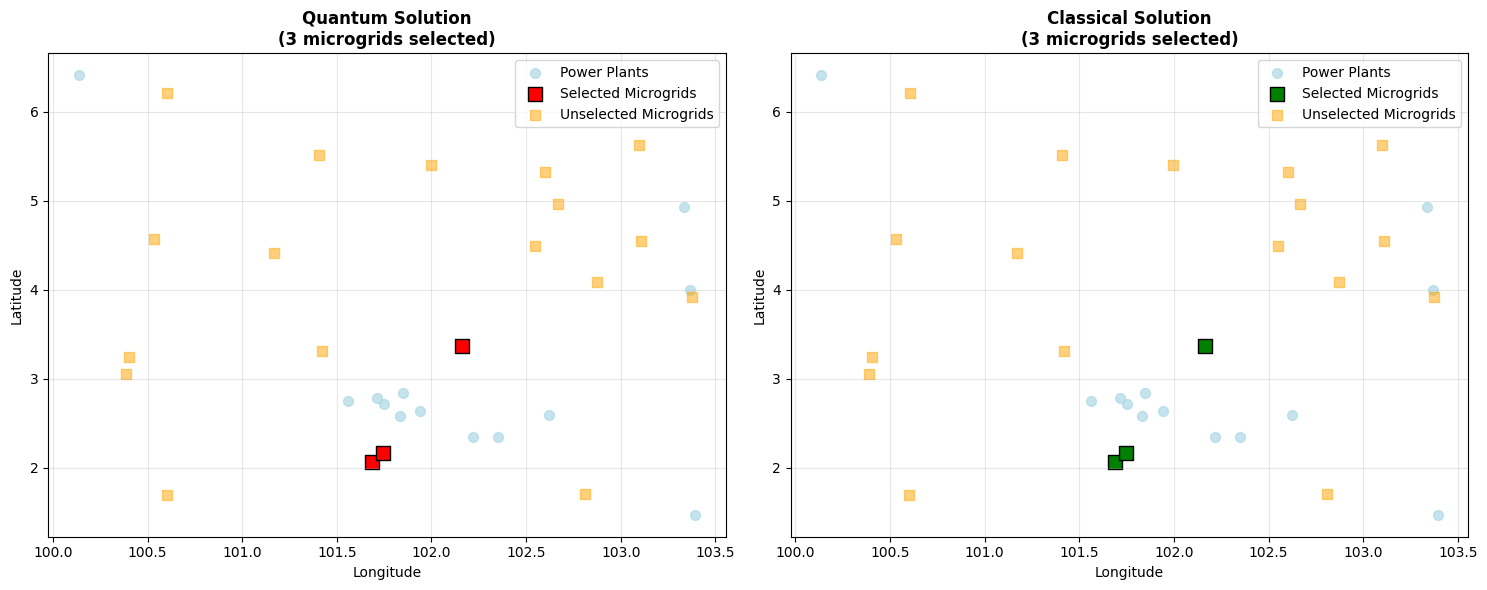

In [209]:
# Add this code after your optimization results in cell 6

import matplotlib.pyplot as plt
import numpy as np

# Calculate metrics for comparison
def calculate_metrics(solution):
    """Calculate various metrics for a given solution"""
    selected_microgrids = sum(solution)
    
    # Total coverage (number of power plants covered)
    total_coverage = num_powerplants if selected_microgrids > 0 else 0
    
    # Total cost calculation
    total_fixed_cost = selected_microgrids * fixedCost
    total_distance_cost = 0
    
    # Calculate distance costs for selected microgrids
    for i in range(num_microgrids):
        if solution[i] == 1:
            total_distance_cost += mgpp_cost[i]
            for j in range(i+1, num_microgrids):
                if solution[j] == 1:
                    total_distance_cost += mgmg_cost[i][j]
    
    total_cost = total_fixed_cost + total_distance_cost
    
    # Energy production (based on selected microgrids and covered power plants)
    total_energy = sum([capacity[i] for i in range(len(capacity)) if any(solution)])
    
    return {
        'selected_microgrids': selected_microgrids,
        'coverage': total_coverage,
        'total_cost': total_cost,
        'energy_production': total_energy,
        'cost_per_mw': total_cost / total_energy if total_energy > 0 else 0
    }

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Quantum vs Classical Microgrid Optimization Comparison', fontsize=16, fontweight='bold')

# 1. Runtime Comparison
methods = ['Quantum (DWave)', 'Classical (Gurobi)']
runtimes = [quantum_time, classical_time]
colors = ['#FF6B6B', '#4ECDC4']

axes[0, 0].bar(methods, runtimes, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 0].set_title('Runtime Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Time (seconds)')
for i, v in enumerate(runtimes):
    axes[0, 0].text(i, v + max(runtimes)*0.01, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')

# 2. Objective Value (Energy) Comparison
energies = [quantum_energy, classical_energy]
axes[0, 1].bar(methods, energies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 1].set_title('Objective Value Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Objective Value')
axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
for i, v in enumerate(energies):
    axes[0, 1].text(i, v + abs(min(energies))*0.01, f'{v:.2e}', ha='center', va='bottom', fontweight='bold', rotation=45)

# 3. Number of Selected Microgrids
selected_mgs = [quantum_metrics['selected_microgrids'], classical_metrics['selected_microgrids']]
axes[0, 2].bar(methods, selected_mgs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 2].set_title('Selected Microgrids', fontweight='bold')
axes[0, 2].set_ylabel('Number of Microgrids')
for i, v in enumerate(selected_mgs):
    axes[0, 2].text(i, v + max(selected_mgs)*0.01, f'{v}', ha='center', va='bottom', fontweight='bold')

# 4. Total Cost Comparison
total_costs = [quantum_metrics['total_cost'], classical_metrics['total_cost']]
axes[1, 0].bar(methods, total_costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_title('Total Implementation Cost', fontweight='bold')
axes[1, 0].set_ylabel('Cost ($)')
axes[1, 0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
for i, v in enumerate(total_costs):
    axes[1, 0].text(i, v + max(total_costs)*0.01, f'{v:.2e}', ha='center', va='bottom', fontweight='bold', rotation=45)

# 5. Energy Production
energy_prod = [quantum_metrics['energy_production'], classical_metrics['energy_production']]
axes[1, 1].bar(methods, energy_prod, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('Total Energy Production', fontweight='bold')
axes[1, 1].set_ylabel('Energy Production (MW)')
for i, v in enumerate(energy_prod):
    axes[1, 1].text(i, v + max(energy_prod)*0.01, f'{v:.1f} MW', ha='center', va='bottom', fontweight='bold')

# 6. Cost Efficiency (Cost per MW)
cost_efficiency = [quantum_metrics['cost_per_mw'], classical_metrics['cost_per_mw']]
axes[1, 2].bar(methods, cost_efficiency, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 2].set_title('Cost Efficiency', fontweight='bold')
axes[1, 2].set_ylabel('Cost per MW ($)')
axes[1, 2].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
for i, v in enumerate(cost_efficiency):
    axes[1, 2].text(i, v + max(cost_efficiency)*0.01, f'{v:.2e}', ha='center', va='bottom', fontweight='bold', rotation=45)

plt.tight_layout()
plt.show()

# Create a detailed comparison table
print("\n" + "="*80)
print("DETAILED COMPARISON RESULTS")
print("="*80)
print(f"{'Metric':<25} {'Quantum (DWave)':<20} {'Classical (Gurobi)':<20} {'Difference':<15}")
print("-"*80)
print(f"{'Runtime (s)':<25} {quantum_time:<20.6f} {classical_time:<20.6f} {abs(quantum_time-classical_time):<15.6f}")
print(f"{'Objective Value':<25} {quantum_energy:<20.2e} {classical_energy:<20.2e} {abs(quantum_energy-classical_energy):<15.2e}")
print(f"{'Selected Microgrids':<25} {quantum_metrics['selected_microgrids']:<20} {classical_metrics['selected_microgrids']:<20} {abs(quantum_metrics['selected_microgrids']-classical_metrics['selected_microgrids']):<15}")
print(f"{'Total Cost ($)':<25} {quantum_metrics['total_cost']:<20.2e} {classical_metrics['total_cost']:<20.2e} {abs(quantum_metrics['total_cost']-classical_metrics['total_cost']):<15.2e}")
print(f"{'Energy Production (MW)':<25} {quantum_metrics['energy_production']:<20.2f} {classical_metrics['energy_production']:<20.2f} {abs(quantum_metrics['energy_production']-classical_metrics['energy_production']):<15.2f}")
print(f"{'Cost per MW ($)':<25} {quantum_metrics['cost_per_mw']:<20.2e} {classical_metrics['cost_per_mw']:<20.2e} {abs(quantum_metrics['cost_per_mw']-classical_metrics['cost_per_mw']):<15.2e}")

# Solution quality analysis
print("\n" + "="*50)
print("SOLUTION QUALITY ANALYSIS")
print("="*50)

if quantum_energy == classical_energy:
    print("✓ Both methods found the SAME optimal solution!")
elif quantum_energy < classical_energy:
    improvement = ((classical_energy - quantum_energy) / abs(classical_energy)) * 100
    print(f"✓ Quantum method found a BETTER solution by {improvement:.2f}%")
else:
    degradation = ((quantum_energy - classical_energy) / abs(classical_energy)) * 100
    print(f"⚠ Classical method found a BETTER solution by {degradation:.2f}%")

if quantum_time < classical_time:
    speedup = classical_time / quantum_time
    print(f"⚡ Quantum method was {speedup:.2f}x FASTER")
else:
    slowdown = quantum_time / classical_time
    print(f"🐌 Classical method was {slowdown:.2f}x FASTER")

# Visualization of selected microgrid locations
plt.figure(figsize=(15, 6))

# Quantum solution visualization
plt.subplot(1, 2, 1)
plt.scatter(long, lat, c='lightblue', s=50, alpha=0.7, label='Power Plants')
selected_quantum = [i for i, x in enumerate(quantum_solution) if x == 1]
if selected_quantum:
    plt.scatter([long_choices[i] for i in selected_quantum], 
               [lat_choices[i] for i in selected_quantum], 
               c='red', s=100, marker='s', label='Selected Microgrids', edgecolor='black')
    plt.scatter([long_choices[i] for i in range(num_microgrids) if i not in selected_quantum], 
               [lat_choices[i] for i in range(num_microgrids) if i not in selected_quantum], 
               c='orange', s=50, alpha=0.5, marker='s', label='Unselected Microgrids')
plt.title(f'Quantum Solution\n({len(selected_quantum)} microgrids selected)', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)

# Classical solution visualization
plt.subplot(1, 2, 2)
plt.scatter(long, lat, c='lightblue', s=50, alpha=0.7, label='Power Plants')
selected_classical = [i for i, x in enumerate(classical_solution) if x == 1]
if selected_classical:
    plt.scatter([long_choices[i] for i in selected_classical], 
               [lat_choices[i] for i in selected_classical], 
               c='green', s=100, marker='s', label='Selected Microgrids', edgecolor='black')
    plt.scatter([long_choices[i] for i in range(num_microgrids) if i not in selected_classical], 
               [lat_choices[i] for i in range(num_microgrids) if i not in selected_classical], 
               c='orange', s=50, alpha=0.5, marker='s', label='Unselected Microgrids')
plt.title(f'Classical Solution\n({len(selected_classical)} microgrids selected)', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()